<a href="https://colab.research.google.com/github/AdrianaLecourieux/Long_project/blob/main/Long__project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⏸ Long Project

Dire ce qu'il y a dans le code 
avec des puces mettre les différentes parties

X modèles de prédictions on été construits, entraînés, évalué et sauvegardés



# 0. Preliminary steps

## 0.1. Import modules and mount drive


Import modules

In [1]:
import pandas as pd       
import numpy as np
import os
import keras
import tensorflow as tf
import cv2 # to open images

# For data visualization
from matplotlib import pyplot as plt # data visualization

# For building models
from tensorflow.keras.models import Sequential # quick and easy
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# For evaluating model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import classification_report

# For confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# For saving model
from tensorflow.keras.models import load_model

# For model interpretation
#import shap


Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.2. Fonction definitions

### 0.2.1 Preprocessing

In [3]:
def get_train_test_validation_split(path, validation_split, seed, img_height, img_width, batch_size):
  '''
  Split dataset into train (70%), test (20%) and validation (10%) sets.

  Parameter
  _________

    path :
      path to the data.
    validation_split : int
      repartition of the data
    seed : int
      set seed
    img_height : int
      height of the image
    img_width : int
      width of the image
    batch_size : int
      size of the batch

  Return
  ______

    Train, test and validation sets.
  '''
  train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split= validation_split,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

  val_batches = tf.data.experimental.cardinality(val_ds)
  test_ds = val_ds.take((2*val_batches) // 3)
  val_ds = val_ds.skip((2*val_batches) // 3)

  return train_ds, test_ds, val_ds

In [4]:
def plot_train_images(train, class_names):
  '''
  Plot exemple of train dataset images.

  Parameter
  _________

    train :
      train set.
    class_names : 
      Name of the classes

  Return
  ______

    Plot of 9 images with legend.
  '''
  plt.figure(figsize=(10, 10))
  for images, labels in train.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

### 0.2.3 Evaluate model

In [5]:
def accuracy_plot(fitting_history):
  '''
  Plots the accuracy against the number of epochs.

  Parameter
  _________

    fitting_history :
      The history of a model.fit.

  Return
  ______

    The accuracy plot.
  '''
  plt.plot(fitting_history.history['accuracy'])
  plt.plot(fitting_history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  
  return plt.show()

In [6]:
def loss_plot(fitting_history):
  '''
  Plots the loss against the number of epochs.

  Parameter
  _________

    fitting_history :
      The history of a model.fit.

  Return
  ______

    The loss plot.
  '''
  plt.plot(fitting_history.history['loss'])
  plt.plot(fitting_history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  
  return plt.show()

In [7]:
def get_evaluation_model(test, model):
  '''
  Evaluate precision, recall and accuracy of the model with test set.

  Parameter
  _________

    test :
      test set
    model :
      keras model

  Return
  ______

    Precision, recall and accuracy values.
  '''
  pre = Precision()
  re = Recall()
  acc = BinaryAccuracy()

  for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

  print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

In [8]:
def confusion_matrix(test,model):
  '''
  Plots the predicted predictions against true values.

  Parameter
  _________

    test :
      test set
    model :
      keras model

  Return
  ______

    The confusion matrix.
  '''
  y_pred = []  # store predicted labels
  y_true = []  # store true labels
  # iterate over the dataset
  for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(preds.round())

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)

  return ConfusionMatrixDisplay.from_predictions(predicted_labels, correct_labels)


## 0.3. Variable definitions

### 0.3.1. Preprocessing

In [9]:
batch_size = 32
img_height = 100
img_width = 100
seed=123
validation_split = 0.3


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


### 0.3.2. Preprocessing

# Part 1

## 1.1. Preprocessing

In [ ]:
data_dir_1 = "/content/drive/MyDrive/long_project/shape_data"

In [ ]:
train, test, validation = get_train_test_validation_split(data_dir_1, validation_split, seed, img_height, img_width, batch_size)

Found 2571 files belonging to 2 classes.
Using 1800 files for training.
Found 2571 files belonging to 2 classes.
Using 771 files for validation.


In [ ]:
class_names = train.class_names
print(class_names)

['non_specific_cells', 'specific_cells']


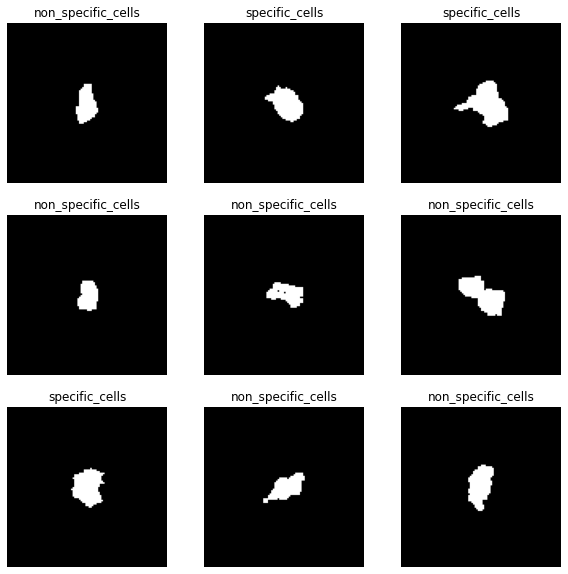

In [ ]:
plot_train_images(train, class_names)

In [ ]:
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

## 1.2 Model

In [ ]:
num_classes = 2
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(
  train,
  validation_data=validation,
  epochs=15
)

Epoch 1/15
57/57 [==============================] - 55s 955ms/step - loss: 0.6605 - accuracy: 0.6100 - val_loss: 0.6276 - val_accuracy: 0.6602
Epoch 2/15
57/57 [==============================] - 9s 158ms/step - loss: 0.6142 - accuracy: 0.6822 - val_loss: 0.5952 - val_accuracy: 0.6911
Epoch 3/15
57/57 [==============================] - 9s 156ms/step - loss: 0.5794 - accuracy: 0.7106 - val_loss: 0.5671 - val_accuracy: 0.7529
Epoch 4/15
57/57 [==============================] - 9s 162ms/step - loss: 0.5255 - accuracy: 0.7467 - val_loss: 0.5044 - val_accuracy: 0.7645
Epoch 5/15
57/57 [==============================] - 12s 209ms/step - loss: 0.4604 - accuracy: 0.7950 - val_loss: 0.4253 - val_accuracy: 0.8224
Epoch 6/15
57/57 [==============================] - 12s 209ms/step - loss: 0.3622 - accuracy: 0.8450 - val_loss: 0.3733 - val_accuracy: 0.8494
Epoch 7/15
57/57 [==============================] - 10s 171ms/step - loss: 0.3060 - accuracy: 0.8678 - val_loss: 0.3140 - val_accuracy: 0.8649
Ep

## 1.3 Evaluate model

### 1.3.1 Plot performance

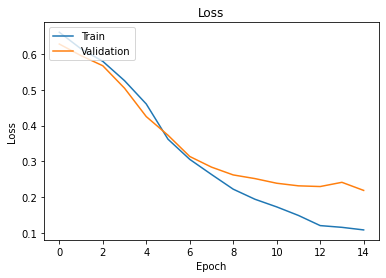

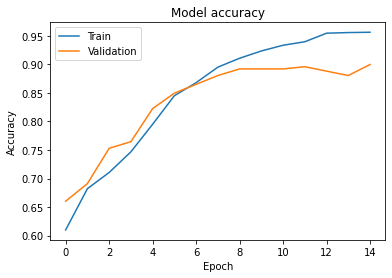

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

loss_plot(history)
print("")
accuracy_plot(history)

### 1.3.2 Evaluate

In [ ]:
get_evaluation_model(test, model)

1/1 [==============================] - 0s 91ms/step
Precision: 0.8399999737739563, Recall: 0.9210526347160339, Accuracy: 0.88671875


### 1.3.3 Confusion matrix

1/1 [==============================] - 0s 83ms/step


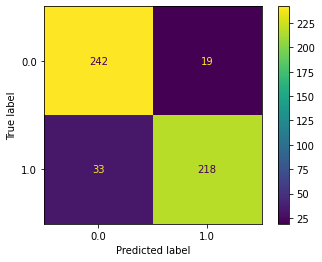

In [ ]:
confusion_matrix(test, model)

In [ ]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       284
           1       0.86      0.93      0.89       228

    accuracy                           0.90       512
   macro avg       0.90      0.91      0.90       512
weighted avg       0.91      0.90      0.90       512



## 1.4 Save the model

In [ ]:
model.save('../content/drive/MyDrive/long_project/saved_models/shape_model')

# Part 2 : Time projection (3 times)

## 2.1 Preprocessing

In [16]:
data_dir_2 = "../content/drive/MyDrive/long_project/Z_projection_data"

In [17]:
train_2, test_2, validation_2 = get_train_test_validation_split(data_dir_2, validation_split, seed, img_height, img_width, batch_size)

Found 3366 files belonging to 2 classes.
Using 2357 files for training.
Found 3366 files belonging to 2 classes.
Using 1009 files for validation.


In [19]:
class_names_2= train_2.class_names
print(class_names_2)

['non_specific_cells_time_projected', 'specific_cells_time_projected']


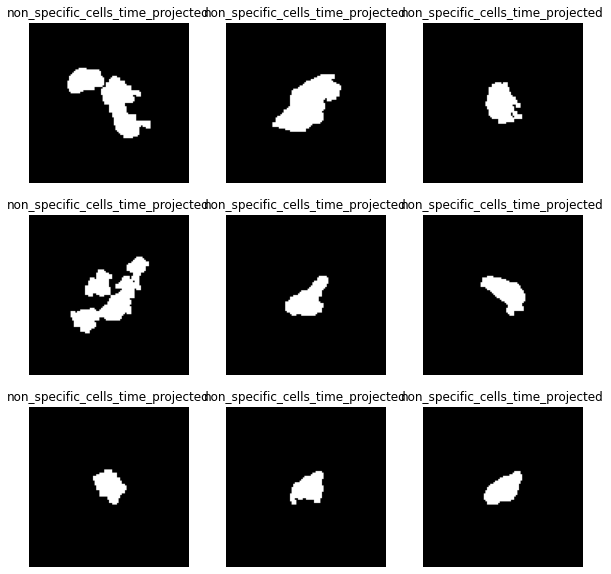

In [20]:
plot_train_images(train_2, class_names_2)

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/long_project/Z_projection_data', image_size=(100,100), seed=True) #building data pipeline

Found 3366 files belonging to 2 classes.


## 2.2. Preprocessing

In [ ]:
data_iterator = data.as_numpy_iterator() #access data pipeline  

In [ ]:
#get an other batch from the iterator
batch = data_iterator.next()

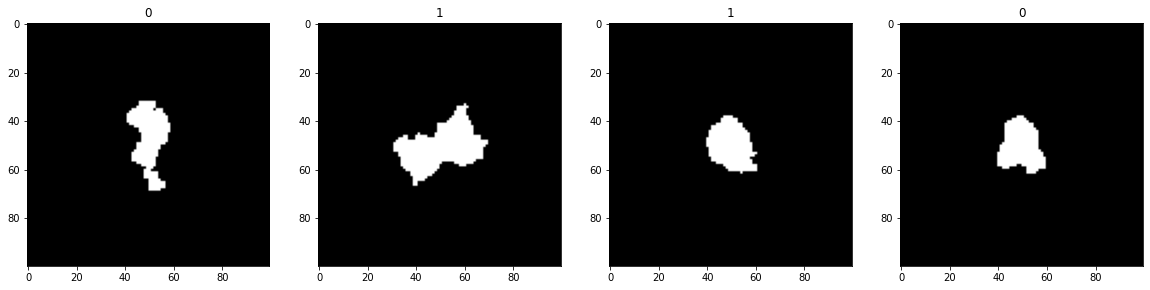

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/255, y)) # map allows to apply particular type of transformation in pipeline
#x : images
#y: labels
#get data, scaled on x and nothing on y

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [ ]:
len(data)

106

In [ ]:
print(train_size+val_size+test_size)

106


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 2.3. Build model

In [ ]:
logdir='logs' 

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [ ]:
model_z = Sequential()  

model_z.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_z.add(MaxPooling2D())
model_z.add(Conv2D(32, (3,3), 1, activation='relu'))
model_z.add(MaxPooling2D())
model_z.add(Conv2D(16, (3,3), 1, activation='relu'))
model_z.add(Dropout(0.2))
model_z.add(MaxPooling2D())
model_z.add(Flatten())
model_z.add(Dense(100, activation='relu'))
model_z.add(Dense(1, activation='sigmoid'))

model_z.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
hist_z = model_z.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
74/74 [==============================] - 180s 2s/step - loss: 0.6193 - accuracy: 0.6588 - val_loss: 0.5735 - val_accuracy: 0.7158
Epoch 2/20
74/74 [==============================] - 27s 365ms/step - loss: 0.5540 - accuracy: 0.7095 - val_loss: 0.5543 - val_accuracy: 0.7277
Epoch 3/20
74/74 [==============================] - 30s 408ms/step - loss: 0.4608 - accuracy: 0.7905 - val_loss: 0.4443 - val_accuracy: 0.8036
Epoch 4/20
74/74 [==============================] - 31s 420ms/step - loss: 0.3362 - accuracy: 0.8644 - val_loss: 0.3320 - val_accuracy: 0.8527
Epoch 5/20
74/74 [==============================] - 31s 421ms/step - loss: 0.2092 - accuracy: 0.9202 - val_loss: 0.2257 - val_accuracy: 0.9122
Epoch 6/20
74/74 [==============================] - 31s 421ms/step - loss: 0.1493 - accuracy: 0.9464 - val_loss: 0.1753 - val_accuracy: 0.9360
Epoch 7/20
74/74 [==============================] - 32s 424ms/step - loss: 0.1037 - accuracy: 0.9649 - val_loss: 0.1130 - val_accuracy: 0.9583
E

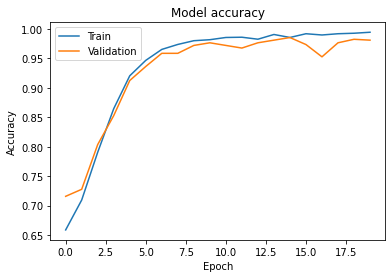

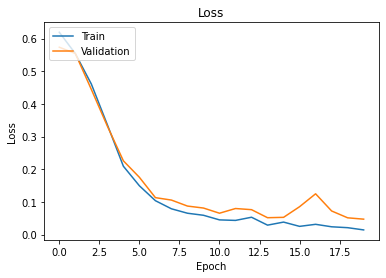

In [ ]:
accuracy_plot(fitting_history = hist_z)
print("")
loss_plot(fitting_history = hist_z)

## 2.4. Evaluate

### 2.4.1. Precision, Recall and Accuracy 

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model_z.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9645389914512634, Recall: 0.9855072498321533, Accuracy: 0.9785276055335999


### 2.4.2. Confusion Matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

In [ ]:
# iterate over the dataset
for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_z.predict(image_batch)
   # append predicted labels
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
print(len(predicted_labels))
len(correct_labels)

326


326

In [ ]:
confusion_matrix(predicted_labels, correct_labels)

array([[180,   2],
       [  3, 141]])

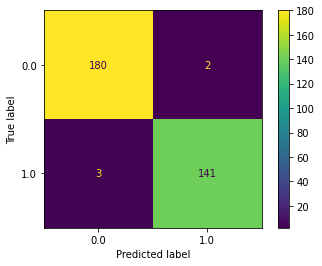

In [ ]:
ConfusionMatrixDisplay.from_predictions(predicted_labels, correct_labels)

### 2.4.3. Classification report

In [ ]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       183
           1       0.98      0.99      0.98       143

    accuracy                           0.98       326
   macro avg       0.98      0.98      0.98       326
weighted avg       0.98      0.98      0.98       326



## 2.5. Save the model

In [ ]:
model_z.save('../content/drive/MyDrive/long_project/saved_models/model_z')

# Part 3 : Classification 3 classes

## 3.1. Load data 

In [ ]:
data_dir = "../content/drive/MyDrive/long_project/supp_data"

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('../content/drive/MyDrive/long_project/supp_data', image_size=(100,100), seed=True) #building data pipeline

Found 4528 files belonging to 3 classes.


## 3.2. Preprocessing

In [ ]:
data_iterator = data.as_numpy_iterator() #access data pipeline  

In [ ]:
#get an other batch from the iterator
batch = data_iterator.next()

In [ ]:
batch[1]

array([2, 1, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 2, 0, 1, 1, 1, 0, 0], dtype=int32)

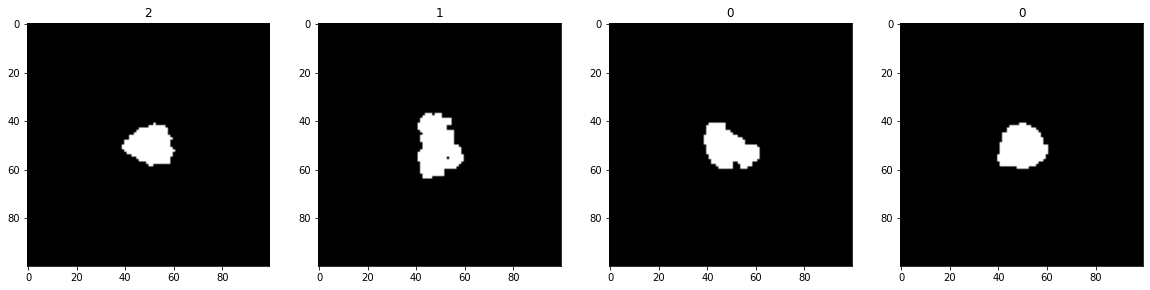

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/255, y)) # map allows to apply particular type of transformation in pipeline
#x : images
#y: labels
#get data, scaled on x and nothing on y

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [ ]:
len(data)

142

In [ ]:
print(train_size+val_size+test_size)

142


In [ ]:
train_3classes = data.take(train_size)
val_3classes = data.skip(train_size).take(val_size)
test_3classes = data.skip(train_size+val_size).take(test_size)

## 3.3. Build model

In [ ]:
logdir='logs' 

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [ ]:
model_3classes = Sequential()  

model_3classes.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_3classes.add(MaxPooling2D())
model_3classes.add(Conv2D(32, (3,3), 1, activation='relu'))
model_3classes.add(MaxPooling2D())
model_3classes.add(Conv2D(16, (3,3), 1, activation='relu'))
model_3classes.add(Dropout(0.2))
model_3classes.add(MaxPooling2D())
model_3classes.add(Flatten())
model_3classes.add(Dense(100, activation='relu'))
model_3classes.add(Dense(3, activation='softmax'))

model_3classes.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist_3classes = model_3classes.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
fig = plt.figure()
plt.plot(hist_3classes.history['loss'], color='teal', label='loss')
plt.plot(hist_3classes.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist_3classes.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_3classes.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model_3classes.evaluate(X, y)
    print(f'Test loss: {yhat[0]} / Test accuracy: {yhat[1]}')
    #pre.update_state(y, yhat)
    #re.update_state(y, yhat)
    #acc.update_state(y, yhat)

## 3.4. Evaluate

### 3.4.1. Confusion Matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

In [ ]:
# iterate over the dataset
for image_batch, label_batch in test_3classes:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_3classes_load.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 79ms/step


In [ ]:
print(len(predicted_labels))
len(correct_labels)

464


464

In [ ]:
confusion_matrix(predicted_labels, correct_labels)

array([[ 83,  38,   3],
       [ 85, 134,  13],
       [  2,   3, 103]])

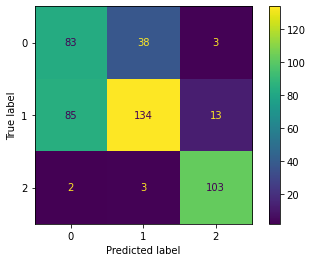

In [ ]:
ConfusionMatrixDisplay.from_predictions(predicted_labels, correct_labels)

### 3.4.2. Classification Report

In [ ]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.67      0.49      0.56       170
           1       0.58      0.77      0.66       175
           2       0.95      0.87      0.91       119

    accuracy                           0.69       464
   macro avg       0.73      0.71      0.71       464
weighted avg       0.71      0.69      0.69       464



## 3.5. Save the model

In [ ]:
model_3classes.save('/content/drive/MyDrive/long_project/saved_models/3_classes_model')

NameError: ignored

## 3.6. test other model

In [ ]:
model_3classes = Sequential()  

model_3classes.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_3classes.add(MaxPooling2D())
model_3classes.add(Conv2D(32, (3,3), 1, activation='relu'))
model_3classes.add(MaxPooling2D())
model_3classes.add(Conv2D(16, (3,3), 1, activation='relu'))
model_3classes.add(Dropout(0.2))
model_3classes.add(MaxPooling2D())
model_3classes.add(Flatten())
model_3classes.add(Dense(100, activation='relu'))
model_3classes.add(Dense(3, activation='softmax'))

model_3classes.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist_3classes = model_3classes.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
99/99 [==============================] - 50s 492ms/step - loss: 1.0285 - accuracy: 0.4495 - val_loss: 1.0176 - val_accuracy: 0.5033
Epoch 2/20
99/99 [==============================] - 43s 422ms/step - loss: 0.9930 - accuracy: 0.4956 - val_loss: 1.0008 - val_accuracy: 0.4855
Epoch 3/20
99/99 [==============================] - 44s 437ms/step - loss: 0.9702 - accuracy: 0.5189 - val_loss: 0.9724 - val_accuracy: 0.5123
Epoch 4/20
99/99 [==============================] - 42s 421ms/step - loss: 0.9248 - accuracy: 0.5603 - val_loss: 0.9442 - val_accuracy: 0.5134
Epoch 5/20
99/99 [==============================] - 55s 558ms/step - loss: 0.7952 - accuracy: 0.6364 - val_loss: 0.7449 - val_accuracy: 0.6652
Epoch 6/20
99/99 [==============================] - 42s 415ms/step - loss: 0.6860 - accuracy: 0.6878 - val_loss: 0.6632 - val_accuracy: 0.6797
Epoch 7/20
99/99 [==============================] - 45s 448ms/step - loss: 0.6030 - accuracy: 0.7222 - val_loss: 0.6137 - val_accuracy: 0.7031

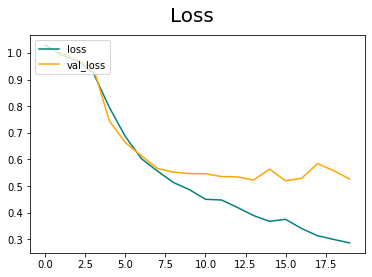

In [ ]:
fig = plt.figure()
plt.plot(hist_3classes.history['loss'], color='teal', label='loss')
plt.plot(hist_3classes.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

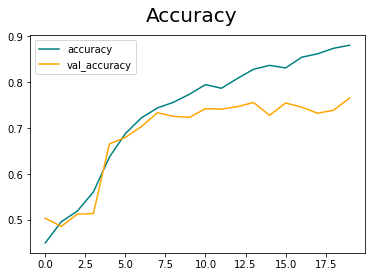

In [ ]:
fig = plt.figure()
plt.plot(hist_3classes.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_3classes.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model_3classes.evaluate(X, y)
    print(f'Test loss: {yhat[0]} / Test accuracy: {yhat[1]}')

1/1 [==============================] - 0s 121ms/step - loss: 0.6932 - accuracy: 0.6562
Test loss: 0.693202018737793 / Test accuracy: 0.65625
1/1 [==============================] - 0s 101ms/step - loss: 0.6499 - accuracy: 0.6562
Test loss: 0.6499220132827759 / Test accuracy: 0.65625
1/1 [==============================] - 0s 113ms/step - loss: 0.5070 - accuracy: 0.7500
Test loss: 0.5069751739501953 / Test accuracy: 0.75
1/1 [==============================] - 0s 92ms/step - loss: 0.8731 - accuracy: 0.6250
Test loss: 0.873073160648346 / Test accuracy: 0.625
1/1 [==============================] - 0s 102ms/step - loss: 0.6647 - accuracy: 0.6250
Test loss: 0.6646722555160522 / Test accuracy: 0.625
1/1 [==============================] - 0s 103ms/step - loss: 0.4672 - accuracy: 0.7188
Test loss: 0.4671630859375 / Test accuracy: 0.71875
1/1 [==============================] - 0s 114ms/step - loss: 0.7854 - accuracy: 0.7500
Test loss: 0.7853817939758301 / Test accuracy: 0.75
1/1 [=================

# Part 4 : Medium and high affinity merged

## 4.1. Load data 

In [ ]:
data_dir = "../content/drive/MyDrive/long_project/medium_high_merged"

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('../content/drive/MyDrive/long_project/medium_high_merged', image_size=(100,100), seed=True) #building data pipeline

Found 4528 files belonging to 2 classes.


## 4.2. Preprocessing

In [ ]:
data_iterator = data.as_numpy_iterator() #access data pipeline  

In [ ]:
#get an other batch from the iterator
batch = data_iterator.next()

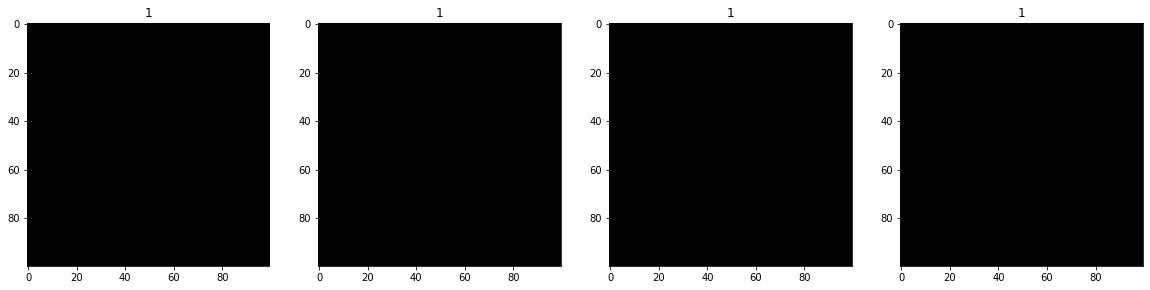

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/255, y)) # map allows to apply particular type of transformation in pipeline
#x : images
#y: labels
#get data, scaled on x and nothing on y

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [ ]:
len(data)

142

In [ ]:
print(train_size+val_size+test_size)

142


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 4.3 Build model

In [ ]:
logdir='logs' 

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [ ]:
model_mh = Sequential()  

model_mh.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_mh.add(MaxPooling2D())
model_mh.add(Conv2D(32, (3,3), 1, activation='relu'))
model_mh.add(MaxPooling2D())
model_mh.add(Conv2D(16, (3,3), 1, activation='relu'))
model_mh.add(Dropout(0.2))
model_mh.add(MaxPooling2D())
model_mh.add(Flatten())
model_mh.add(Dense(100, activation='relu'))
model_mh.add(Dense(1, activation='sigmoid'))

model_mh.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
hist_mh = model_mh.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

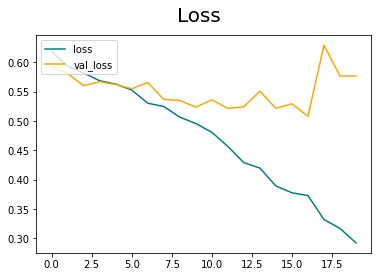

In [ ]:
fig = plt.figure()
plt.plot(hist_mh.history['loss'], color='teal', label='loss')
plt.plot(hist_mh.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

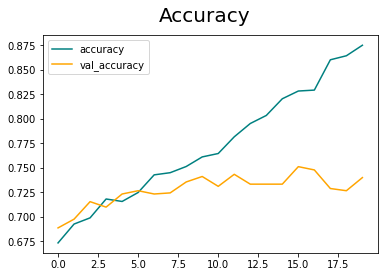

In [ ]:
fig = plt.figure()
plt.plot(hist_mh.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_mh.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 4.4. Evaluate

### 4.4.1. Precision, Recall and Accuracy 

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model_mh.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.6836158037185669, Recall: 0.8864468932151794, Accuracy: 0.6918103694915771


### 4.4.2. Confusion Matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

In [ ]:
# iterate over the dataset
for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_mh.predict(image_batch)
   # append predicted labels
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
print(len(predicted_labels))
len(correct_labels)

464


464

In [ ]:
confusion_matrix(predicted_labels, correct_labels)

array([[ 80,  39],
       [103, 242]])

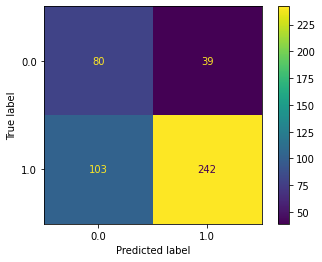

In [ ]:
ConfusionMatrixDisplay.from_predictions(predicted_labels, correct_labels)

### 4.4.3. Classification report

In [ ]:
print(classification_report(correct_labels, predicted_labels))

## 4.5. Save the model

In [ ]:
model_dropout.save('../content/drive/MyDrive/long_project/saved_models/XX')

# Part 5 : Tests on tumor films

## 5.1. Test tumor films on model 1

Load the model

In [ ]:
shape_model = load_model('../content/drive/MyDrive/long_project/saved_models/shape_model')

### 5.1.1 Non-specific

In [ ]:
non_spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop'

In [ ]:
os.listdir(non_spe_model_1 )

In [ ]:
ypred = []
name_bad_prediction = []
name_good_prediction = []
for image in os.listdir(non_spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop/{image}')
  preds = shape_model.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())
  if preds.round() == 1:
    name_bad_prediction.append(image)
  else:
    name_good_prediction.append(image)


In [ ]:
name_good_prediction

In [ ]:
len(name_good_prediction)

375

In [ ]:
name_bad_prediction

In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

405

In [ ]:
correct_labels = np.full((405),0)
len(correct_labels)

405

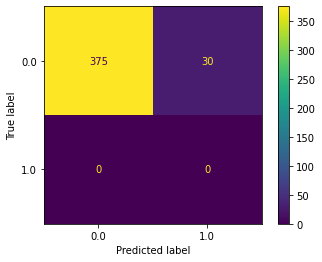

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 5.1.2. Specific

In [ ]:
spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop'

In [ ]:
os.listdir(spe_model_1)

In [ ]:
ypred = []
name_bad_prediction = []
name_good_prediction = []
for image in os.listdir(spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop/{image}')
  preds = shape_model.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())
  if preds.round() == 0:
    name_bad_prediction.append(image)
  else:
    name_good_prediction.append(image)

1/1 [==============================] - 0s 23ms/step


In [ ]:
len(name_bad_prediction)

837

In [ ]:
name_good_prediction

['Tumor_Ag_specifique_PB2_24_373_282.png',
 'Tumor_Ag_specifique_PB2_5_402_401.png',
 'Tumor_Ag_specifique_PB2_3_368_279.png',
 'Tumor_Ag_specifique_PB2_7_368_443.png',
 'Tumor_Ag_specifique_PB2_14_371_279.png',
 'Tumor_Ag_specifique_PB2_59_409_171.png',
 'Tumor_Ag_specifique_PB2_75_408_396.png',
 'Tumor_Ag_specifique_PB2_58_366_445.png',
 'Tumor_Ag_specifique_PB2_76_365_446.png',
 'Tumor_Ag_specifique_PB2_34_371_281.png',
 'Tumor_Ag_specifique_PB2_38_365_443.png',
 'Tumor_Ag_specifique_PB2_54_372_283.png',
 'Tumor_Ag_specifique_PB2_71_169_271.png',
 'Tumor_Ag_specifique_PB2_50_408_170.png',
 'Tumor_Ag_specifique_PB2_44_372_281.png',
 'Tumor_Ag_specifique_PB2_64_382_313.png',
 'Tumor_Ag_specifique_PB2_43_174_279.png',
 'Tumor_Ag_specifique_PB2_29_365_443.png',
 'Tumor_Ag_specifique_PB2_48_363_443.png',
 'Tumor_Ag_specifique_PB2_63_370_283.png',
 'Tumor_Ag_specifique_PB2_83_368_285.png',
 'Tumor_Ag_specifique_PB2_120_359_282.png',
 'Tumor_Ag_specifique_PB2_86_363_446.png',
 'Tumor_Ag_sp

In [ ]:
len(name_good_prediction)

131

In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

968

In [ ]:
correct_labels = np.full((968),1)
len(correct_labels)

968

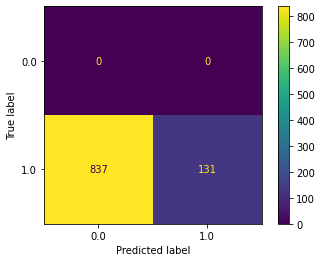

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

## 5.1.3 Test with data augmentation

In [ ]:
non_spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop'

In [ ]:
os.listdir(non_spe_model_1 )

In [ ]:
ypred = []
for image in os.listdir(non_spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop/{image}')
  preds = model.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())
  score = tf.nn.sigmoid(preds[0])
  print(class_names[np.argmax(score)])

In [ ]:
score = tf.nn.sigmoid(preds[0])
class_names[np.argmax(score)]

'non_specific_cells_copy_paste'

In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

405

In [ ]:
correct_labels = np.full((405),0)
len(correct_labels)

405

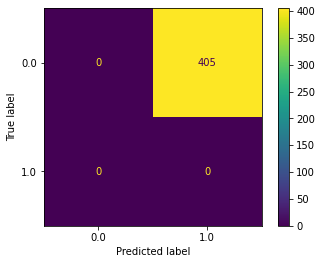

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 5.3.2 Specific

In [ ]:
spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop'

In [ ]:
ypred = []
for image in os.listdir(spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop/{image}')
  preds = model.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())
  score = tf.nn.sigmoid(preds[0])
  print(class_names[np.argmax(score)])


In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

968

In [ ]:
correct_labels = np.full((968),1)
len(correct_labels)

968

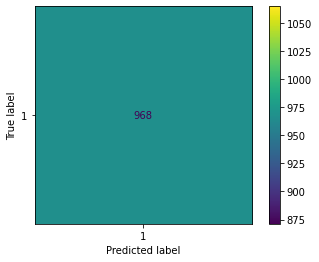

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

## 5.2. Test on 3 classes

Load the model

In [ ]:
model_3classes_load = load_model('/content/drive/MyDrive/long_project/saved_models/3_classes_model')

### 5.2.1 Non-specific

In [ ]:
non_specific_3classes = '/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop'

In [ ]:
non_specific_3_classes_pred = []
for image in os.listdir(non_specific_3classes):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop/{image}')
  preds = model_3classes_load.predict(np.expand_dims(img/255, 0))
  predictions = non_specific_3_classes_pred.append(np.argmax(preds, axis = - 1))


In [ ]:
predicted_labels = tf.concat([item for item in non_specific_3_classes_pred], axis = 0)

In [ ]:
len(predicted_labels)

405

In [ ]:
correct_labels = np.full((405),0)
len(correct_labels)

405

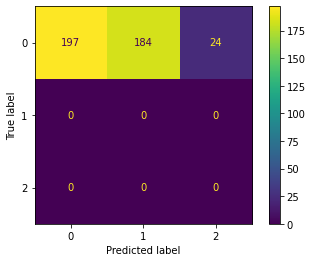

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 5.2.2. Specific

In [ ]:
specific_3classes = '/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop'

In [ ]:
specific_3_classes_pred = []
for image in os.listdir(specific_3classes):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop/{image}')
  preds = model_3classes_load.predict(np.expand_dims(img/255, 0))
  predictions = specific_3_classes_pred.append(np.argmax(preds, axis = - 1))
  


In [ ]:
predicted_labels_specific = tf.concat([item for item in specific_3_classes_pred], axis = 0)

In [ ]:
len(predicted_labels_specific)

968

In [ ]:
correct_labels_specific = np.full((968),2)
len(correct_labels_specific)

968

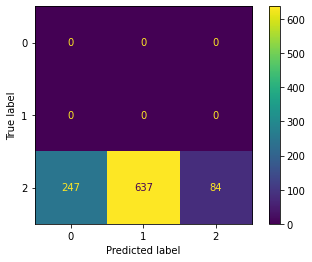

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels_specific, predicted_labels_specific)

## 5.3. Test on Z projection binary classification

Load the model

In [ ]:
z_projection_model1 = load_model('../content/drive/MyDrive/long_project/saved_models/model_z')

### 5.1.1 Non-specific

In [ ]:
non_spe_model_1_z_proj = '/content/drive/MyDrive/long_project/tumor_data_z_projection/Tumor_non_specifique_PB2_Z_projected_stack_crop'

In [ ]:
ypred = []
for image in os.listdir(non_spe_model_1_z_proj):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data_z_projection/Tumor_non_specifique_PB2_Z_projected_stack_crop/{image}')
  preds = z_projection_model1.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

461

In [ ]:
correct_labels = np.full((461),0)
len(correct_labels)

461

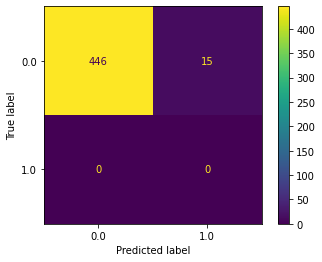

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 5.1.2. Specific

In [ ]:
spe_model_1_z_proj = '/content/drive/MyDrive/long_project/tumor_data_z_projection/Tumor_Ag_specifique_PB2_Z_projected_stack_crop'

In [ ]:
ypred = []
for image in os.listdir(spe_model_1_z_proj):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data_z_projection/Tumor_Ag_specifique_PB2_Z_projected_stack_crop/{image}')
  preds = z_projection_model1.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

1300

In [ ]:
correct_labels = np.full((1300),1)
len(correct_labels)

1300

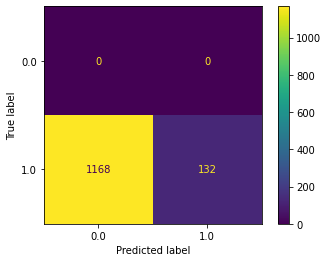

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

## 5.4 Test on model medium + high merged


# Test bug

En partant du model non save : marche toujours pas
quand on prédit sur les données déjà entrainées : prédit bien

In [ ]:
spe_model_1_z_proj = '/content/drive/MyDrive/long_project/Z_projection_data/non_specific_cells_Z_projected_stack_Z_projected'

In [ ]:
ypred = []
for image in os.listdir(spe_model_1_z_proj):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/Z_projection_data/non_specific_cells_Z_projected_stack_Z_projected/{image}')
  preds = model_z.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


NameError: ignored

In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

In [ ]:
correct_labels = np.full((1866),1)
len(correct_labels)

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

# 6. Test on cell edges

## 1.1. Load data

In [ ]:
data_dir = "../content/drive/MyDrive/long_project"

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('../content/drive/MyDrive/long_project/shape_data_edges', image_size=(100,100), seed=True) #building data pipeline

Found 2733 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator() #access data pipeline  

In [ ]:
#get an other batch from the iterator
batch = data_iterator.next()

Visualize data

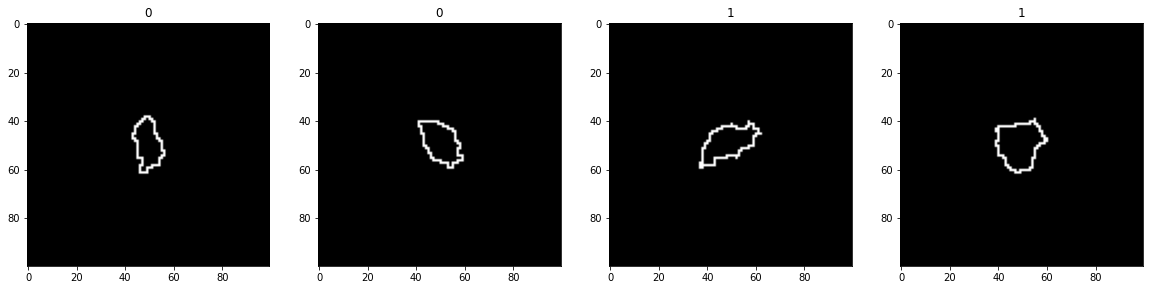

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Batch is composed of two parts : images (batch[0]) and labels (batch[1])

## 1.2. Preprocessing

Data scale

In [ ]:
data = data.map(lambda x,y: (x/255, y)) # map allows to apply particular type of transformation in pipeline
#x : images
#y: labels
#get data, scaled on x and nothing on y

In [ ]:
data.as_numpy_iterator().next()[0].max()

1.0

Split data

In [ ]:
len(data)

86

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [ ]:
print(train_size+val_size+test_size)

86


take defines how much data we take in this partition
skip : skip batches already allocated

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 1.3. Build the model

### 1.4.2.1 Build CNN

Create a log directory

In [ ]:
logdir='logs' 

Create callbacks (usefull to save model at a particular checkpoint, do specific logging..)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [ ]:
model_edges = Sequential()  

model_edges.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_edges.add(MaxPooling2D())
model_edges.add(Conv2D(32, (3,3), 1, activation='relu'))
model_edges.add(MaxPooling2D())
model_edges.add(Conv2D(16, (3,3), 1, activation='relu'))
model_edges.add(Dropout(0.2))
model_edges.add(MaxPooling2D())
model_edges.add(Flatten())
model_edges.add(Dense(100, activation='relu'))
model_edges.add(Dense(1, activation='sigmoid'))

model_edges.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
hist_edges = model_edges.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
60/60 [==============================] - 474s 8s/step - loss: 0.6558 - accuracy: 0.6177 - val_loss: 0.6240 - val_accuracy: 0.6728
Epoch 2/15
60/60 [==============================] - 23s 374ms/step - loss: 0.6077 - accuracy: 0.6776 - val_loss: 0.6259 - val_accuracy: 0.6434
Epoch 3/15
60/60 [==============================] - 22s 368ms/step - loss: 0.5810 - accuracy: 0.6943 - val_loss: 0.5631 - val_accuracy: 0.7206
Epoch 4/15
60/60 [==============================] - 22s 367ms/step - loss: 0.5481 - accuracy: 0.7234 - val_loss: 0.5557 - val_accuracy: 0.7077
Epoch 5/15
60/60 [==============================] - 23s 372ms/step - loss: 0.4927 - accuracy: 0.7703 - val_loss: 0.5497 - val_accuracy: 0.6967
Epoch 6/15
60/60 [==============================] - 24s 402ms/step - loss: 0.4526 - accuracy: 0.7958 - val_loss: 0.4695 - val_accuracy: 0.7904
Epoch 7/15
60/60 [==============================] - 22s 364ms/step - loss: 0.4032 - accuracy: 0.8240 - val_loss: 0.4527 - val_accuracy: 0.7886
E

### 1.4.2.2 Plot performance 

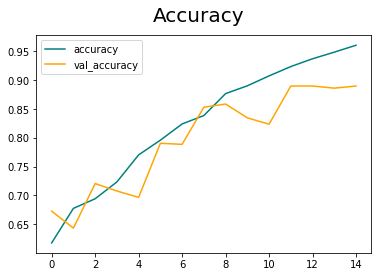

In [ ]:
fig = plt.figure()
plt.plot(hist_edges.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_edges.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

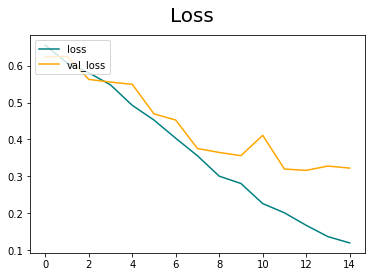

In [ ]:
fig = plt.figure()
plt.plot(hist_edges.history['loss'], color='teal', label='loss')
plt.plot(hist_edges.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 1.4. Evaluate

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model_edges.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 111ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.901098906993866, Recall: 0.7884615659713745, Accuracy: 0.8847583532333374


### 1.X Confusion matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

In [ ]:
# iterate over the dataset
for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_edges.predict(image_batch)
   # append predicted labels
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 50ms/step


In [ ]:
print(len(predicted_labels))
len(correct_labels)

269


269

In [ ]:
confusion_matrix(predicted_labels, correct_labels)

array([[157,  22],
       [  2,  88]])

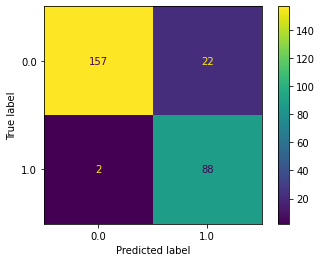

In [ ]:
ConfusionMatrixDisplay.from_predictions(predicted_labels, correct_labels)

In [ ]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       159
           1       0.98      0.80      0.88       110

    accuracy                           0.91       269
   macro avg       0.93      0.89      0.90       269
weighted avg       0.92      0.91      0.91       269



## 6. Save model

In [ ]:
model_edges.save('../content/drive/MyDrive/long_project/saved_models/model_edges')

# 6. Test on tumor cells

### 6.. Specific

In [ ]:
spe_model_1 = '/content/drive/MyDrive/long_project/tumors_edges_data/Tumor_Ag_specifique_PB2_find_edges'

In [ ]:
ypred = []
for image in os.listdir(spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumors_edges_data/Tumor_Ag_specifique_PB2_find_edges/{image}')
  preds = model_edges.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

946

In [ ]:
correct_labels = np.full((946),1)
len(correct_labels)

946

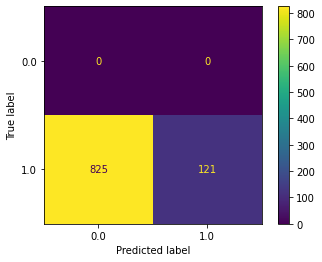

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 6.. Non-specific

In [ ]:
non_spe_model = '/content/drive/MyDrive/long_project/tumors_edges_data/Tumor_non_specifique_PB2_find_edges'

In [ ]:
ypred = []
for image in os.listdir(non_spe_model):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumors_edges_data/Tumor_non_specifique_PB2_find_edges/{image}')
  preds = model_edges.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

328

In [ ]:
correct_labels = np.full((328),0)
len(correct_labels)

328

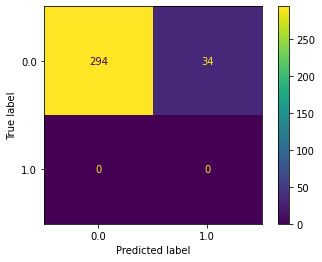

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

# Part 1 : Predict Ag affinity from the shape of the cells

## 1.1. Load data

In [ ]:
data_dir = "../content/drive/MyDrive/long_project"

In [ ]:
os.listdir(data_dir)

['shape_data',
 'Z_projection_data',
 'supp_data',
 'saved_models',
 'tumor_data',
 'medium_high_merged',
 'tumor_data_z_projection',
 'shape_data_edges',
 'tumors_edges_data']

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('../content/drive/MyDrive/long_project/shape_data', image_size=(100,100), seed=True) #building data pipeline

Found 2571 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator() #access data pipeline  

In [ ]:
#get an other batch from the iterator
batch = data_iterator.next()

In [ ]:
batch[0].shape #images represented as np arrays

(32, 100, 100, 3)

In [ ]:
batch[1] #images represented as classe

# 0 : non specific
# 1 : specific

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

Visualize data

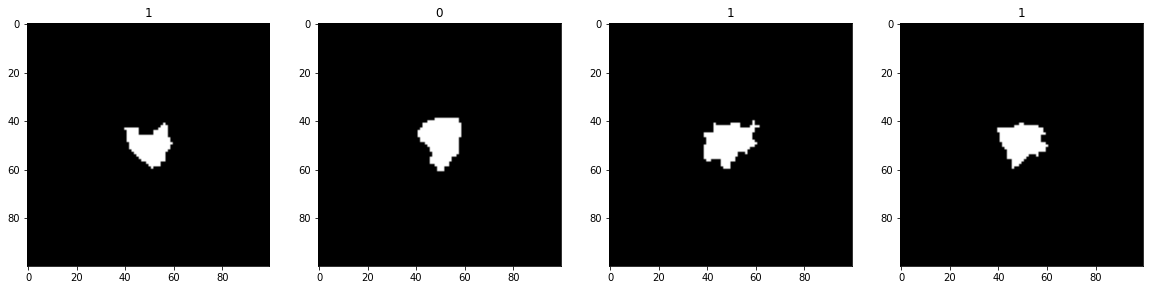

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Batch is composed of two parts : images (batch[0]) and labels (batch[1])

## 1.2. Preprocessing

Data scale

In [ ]:
data = data.map(lambda x,y: (x/255, y)) # map allows to apply particular type of transformation in pipeline
#x : images
#y: labels
#get data, scaled on x and nothing on y

In [ ]:
data.as_numpy_iterator().next()[0].max()

1.0

Split data

In [ ]:
len(data)

81

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [ ]:
print(train_size+val_size+test_size)

81


take defines how much data we take in this partition
skip : skip batches already allocated

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 1.3. Build the model

### 1.4.2.1 Build CNN

Create a log directory

In [ ]:
logdir='logs' 

Create callbacks (usefull to save model at a particular checkpoint, do specific logging..)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [ ]:
model_dropout = Sequential()  

model_dropout.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_dropout.add(MaxPooling2D())
model_dropout.add(Conv2D(32, (3,3), 1, activation='relu'))
model_dropout.add(MaxPooling2D())
model_dropout.add(Conv2D(16, (3,3), 1, activation='relu'))
model_dropout.add(Dropout(0.2))
model_dropout.add(MaxPooling2D())
model_dropout.add(Flatten())
model_dropout.add(Dense(100, activation='relu'))
model_dropout.add(Dense(1, activation='sigmoid'))

model_dropout.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
hist_dropout = model_dropout.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
56/56 [==============================] - 256s 5s/step - loss: 0.6711 - accuracy: 0.5988 - val_loss: 0.6257 - val_accuracy: 0.6836
Epoch 2/20
56/56 [==============================] - 20s 355ms/step - loss: 0.6260 - accuracy: 0.6434 - val_loss: 0.5984 - val_accuracy: 0.6836
Epoch 3/20
56/56 [==============================] - 20s 357ms/step - loss: 0.6001 - accuracy: 0.6763 - val_loss: 0.5779 - val_accuracy: 0.6875
Epoch 4/20
56/56 [==============================] - 25s 451ms/step - loss: 0.5518 - accuracy: 0.7182 - val_loss: 0.5465 - val_accuracy: 0.7305
Epoch 5/20
56/56 [==============================] - 23s 398ms/step - loss: 0.5093 - accuracy: 0.7461 - val_loss: 0.4772 - val_accuracy: 0.7930
Epoch 6/20
56/56 [==============================] - 20s 357ms/step - loss: 0.4008 - accuracy: 0.8309 - val_loss: 0.4141 - val_accuracy: 0.8105
Epoch 7/20
56/56 [==============================] - 26s 451ms/step - loss: 0.3464 - accuracy: 0.8493 - val_loss: 0.3088 - val_accuracy: 0.8887
E

### 1.4.2.2 Plot performance 

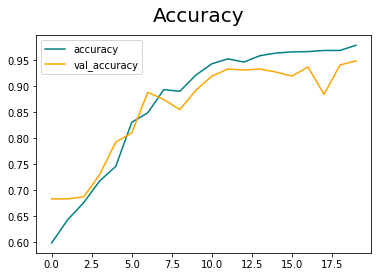

In [ ]:
fig = plt.figure()
plt.plot(hist_dropout.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_dropout.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

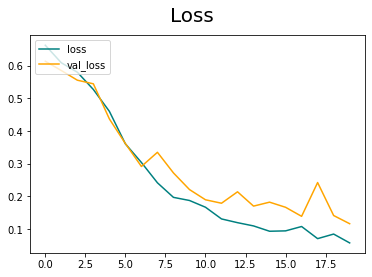

In [ ]:
fig = plt.figure()
plt.plot(hist_dropout.history['loss'], color='teal', label='loss')
plt.plot(hist_dropout.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 1.4. Evaluate

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model_dropout.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 108ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9322034120559692, Recall: 0.8661417365074158, Accuracy: 0.9063670635223389


### 1.X Confusion matrix

In [ ]:
shape_model = load_model('../content/drive/MyDrive/long_project/saved_models/shape_model')

In [ ]:
shape_model

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels


In [ ]:
test_image = []
# iterate over the dataset
for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = shape_model.predict(image_batch)
   # append predicted labels
   y_pred.append(preds.round())
   if preds.round() == 0:
     test_image.append(image_batch)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 86ms/step


ValueError: ignored

In [ ]:
test.class_names

AttributeError: ignored

In [ ]:
test

<TakeDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
print(len(predicted_labels))
len(correct_labels)

267


267

In [ ]:
confusion_matrix(predicted_labels, correct_labels)

array([[145,  16],
       [  8,  98]])

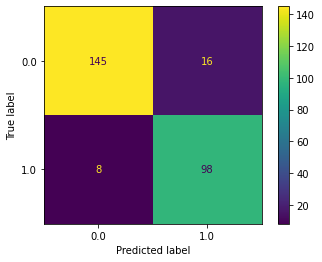

In [ ]:
ConfusionMatrixDisplay.from_predictions(predicted_labels, correct_labels)

In [ ]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       153
           1       0.92      0.86      0.89       114

    accuracy                           0.91       267
   macro avg       0.91      0.90      0.91       267
weighted avg       0.91      0.91      0.91       267



## 1.5. Save the model

In [ ]:
model_dropout.save('../content/drive/MyDrive/long_project/saved_models/shape_model')

## 1.7. Neural Network

### I.4.1. Test architecture

### 1.4.1.1 Classic CNN

In [ ]:
model = Sequential()  
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(44,44,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(44, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 42, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 16)         0

Train

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
56/56 [==============================] - 228s 4s/step - loss: 0.6631 - accuracy: 0.6116 - val_loss: 0.6361 - val_accuracy: 0.6426
Epoch 2/20
56/56 [==============================] - 10s 181ms/step - loss: 0.6207 - accuracy: 0.6669 - val_loss: 0.6240 - val_accuracy: 0.6562
Epoch 3/20
56/56 [==============================] - 10s 167ms/step - loss: 0.5931 - accuracy: 0.6987 - val_loss: 0.5665 - val_accuracy: 0.7129
Epoch 4/20
56/56 [==============================] - 11s 180ms/step - loss: 0.5572 - accuracy: 0.7126 - val_loss: 0.5506 - val_accuracy: 0.7031
Epoch 5/20
56/56 [==============================] - 8s 141ms/step - loss: 0.5330 - accuracy: 0.7422 - val_loss: 0.5348 - val_accuracy: 0.7246
Epoch 6/20
56/56 [==============================] - 8s 143ms/step - loss: 0.5011 - accuracy: 0.7567 - val_loss: 0.5178 - val_accuracy: 0.7383
Epoch 7/20
56/56 [==============================] - 8s 140ms/step - loss: 0.4747 - accuracy: 0.7785 - val_loss: 0.5315 - val_accuracy: 0.7246
Epoc

Plot performance

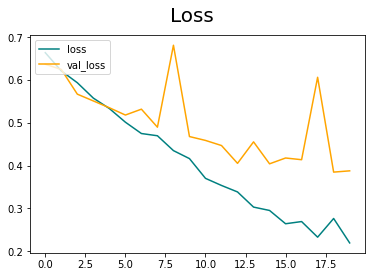

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

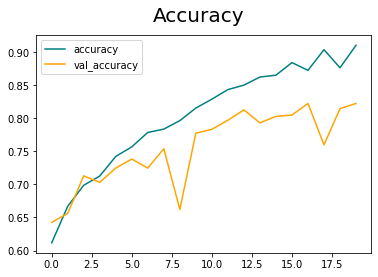

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

overfitting => need regularizarion

### 1.4.1.2 CNN with L2 regularization

In [ ]:
model_l2 = Sequential()  
model_l2.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(44,44,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_l2.add(MaxPooling2D())
model_l2.add(Conv2D(32, (3,3), 1, activation='relu'))
model_l2.add(MaxPooling2D())
model_l2.add(Conv2D(16, (3,3), 1, activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
model_l2.add(MaxPooling2D())
model_l2.add(Flatten())
model_l2.add(Dense(44, activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
model_l2.add(Dense(1, activation='sigmoid'))

In [ ]:
model_l2.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
hist_l2 = model_l2.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
56/56 [==============================] - 11s 184ms/step - loss: 1.2373 - accuracy: 0.6027 - val_loss: 1.0000 - val_accuracy: 0.6172
Epoch 2/20
56/56 [==============================] - 10s 182ms/step - loss: 0.8855 - accuracy: 0.6334 - val_loss: 0.8060 - val_accuracy: 0.6484
Epoch 3/20
56/56 [==============================] - 10s 169ms/step - loss: 0.7483 - accuracy: 0.6758 - val_loss: 0.7685 - val_accuracy: 0.6152
Epoch 4/20
56/56 [==============================] - 10s 167ms/step - loss: 0.6990 - accuracy: 0.6836 - val_loss: 0.7071 - val_accuracy: 0.6426
Epoch 5/20
56/56 [==============================] - 9s 163ms/step - loss: 0.6610 - accuracy: 0.7031 - val_loss: 0.6473 - val_accuracy: 0.6875
Epoch 6/20
56/56 [==============================] - 9s 151ms/step - loss: 0.6411 - accuracy: 0.7148 - val_loss: 0.6700 - val_accuracy: 0.6641
Epoch 7/20
56/56 [==============================] - 9s 152ms/step - loss: 0.6162 - accuracy: 0.7221 - val_loss: 0.6098 - val_accuracy: 0.7070
Ep

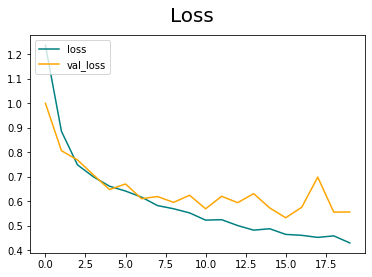

In [ ]:
fig = plt.figure()
plt.plot(hist_l2.history['loss'], color='teal', label='loss')
plt.plot(hist_l2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

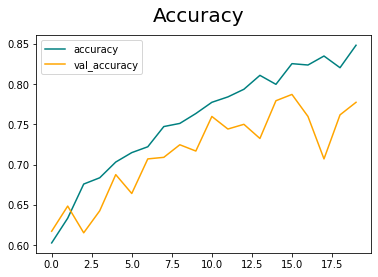

In [ ]:
fig = plt.figure()
plt.plot(hist_l2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_l2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 1.4.1.3 Model with Dropout + l2

In [ ]:
model_D = Sequential()  

model_D.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_D.add(MaxPooling2D())
model_D.add(Conv2D(32, (3,3), 1, activation='relu'))
model_D.add(MaxPooling2D())
model_D.add(Conv2D(16, (3,3), 1, activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
model_D.add(Dropout(0.2))
model_D.add(MaxPooling2D())
model_D.add(Flatten())
model_D.add(Dense(100, activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
model_D.add(Dense(1, activation='sigmoid'))

model_D.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
hist_D = model_D.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
56/56 [==============================] - 23s 383ms/step - loss: 1.3996 - accuracy: 0.5798 - val_loss: 0.8054 - val_accuracy: 0.6133
Epoch 2/20
56/56 [==============================] - 22s 381ms/step - loss: 0.7428 - accuracy: 0.6484 - val_loss: 0.6955 - val_accuracy: 0.6777
Epoch 3/20
56/56 [==============================] - 21s 373ms/step - loss: 0.6858 - accuracy: 0.6624 - val_loss: 0.6738 - val_accuracy: 0.6777
Epoch 4/20
56/56 [==============================] - 22s 388ms/step - loss: 0.6637 - accuracy: 0.6702 - val_loss: 0.6495 - val_accuracy: 0.7109
Epoch 5/20
56/56 [==============================] - 27s 475ms/step - loss: 0.6391 - accuracy: 0.6953 - val_loss: 0.6275 - val_accuracy: 0.7363
Epoch 6/20
56/56 [==============================] - 27s 477ms/step - loss: 0.6015 - accuracy: 0.7400 - val_loss: 0.5824 - val_accuracy: 0.7520
Epoch 7/20
56/56 [==============================] - 21s 368ms/step - loss: 0.5416 - accuracy: 0.7785 - val_loss: 0.6267 - val_accuracy: 0.7012

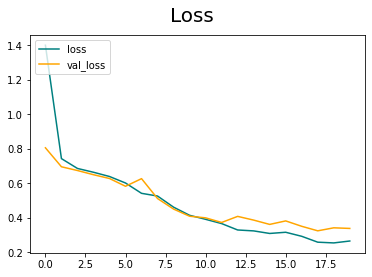

In [ ]:
fig = plt.figure()
plt.plot(hist_D.history['loss'], color='teal', label='loss')
plt.plot(hist_D.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

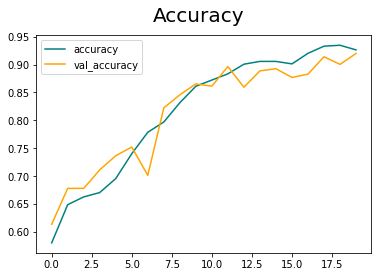

In [ ]:
fig = plt.figure()
plt.plot(hist_D.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_D.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 1.X test on tumor

In [ ]:
spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop'

In [ ]:
os.listdir(spe_model_1)

In [ ]:
ypred = []
for image in os.listdir(spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop/{image}')
  preds = model.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

968

In [ ]:
correct_labels = np.full((968),1)
len(correct_labels)

968

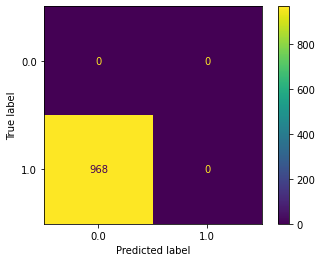

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

## 1.6. Data augmentation 

In [ ]:
img_height = 100
img_width = 100

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

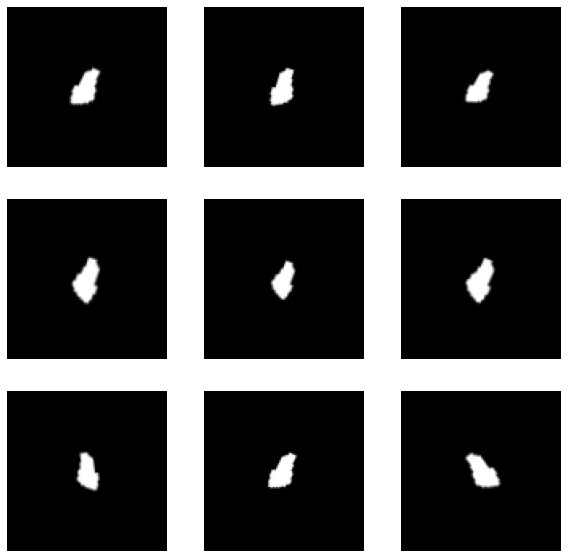

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 2
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
65/65 [==============================] - 22s 320ms/step - loss: 0.6603 - accuracy: 0.6014 - val_loss: 0.5999 - val_accuracy: 0.6984
Epoch 2/15
65/65 [==============================] - 21s 318ms/step - loss: 0.6353 - accuracy: 0.6539 - val_loss: 0.5822 - val_accuracy: 0.7335
Epoch 3/15
65/65 [==============================] - 21s 316ms/step - loss: 0.6282 - accuracy: 0.6534 - val_loss: 0.5765 - val_accuracy: 0.7198
Epoch 4/15
65/65 [==============================] - 21s 331ms/step - loss: 0.6240 - accuracy: 0.6553 - val_loss: 0.5795 - val_accuracy: 0.7179
Epoch 5/15
65/65 [==============================] - 21s 322ms/step - loss: 0.6147 - accuracy: 0.6602 - val_loss: 0.5701 - val_accuracy: 0.7276
Epoch 6/15
65/65 [==============================] - 21s 317ms/step - loss: 0.6081 - accuracy: 0.6665 - val_loss: 0.5655 - val_accuracy: 0.7140
Epoch 7/15
65/65 [==============================] - 20s 313ms/step - loss: 0.6106 - accuracy: 0.6719 - val_loss: 0.5460 - val_accuracy: 0.7315

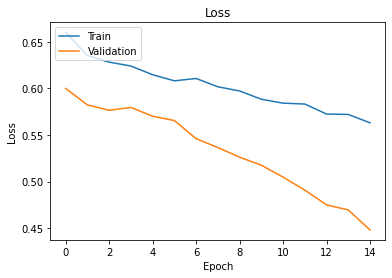

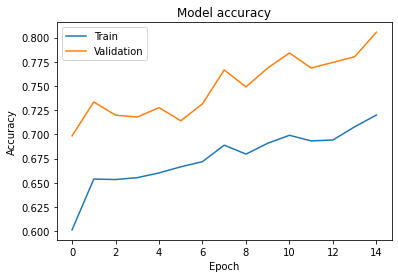

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

loss_plot(history)
accuracy_plot(history)

In [ ]:
## 1.7 SHAP

# 1. Without /255

In [ ]:
data_dir = "../content/drive/MyDrive/long_project"

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('../content/drive/MyDrive/long_project/shape_data', image_size=(100,100), seed=True) #building data pipeline

Found 2571 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator() #access data pipeline  

In [ ]:
#get an other batch from the iterator
batch = data_iterator.next()

In [ ]:
batch[0].shape #images represented as np arrays

(32, 100, 100, 3)

In [ ]:
batch[1] #images represented as classe

# 0 : non specific
# 1 : specific

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

Visualize data

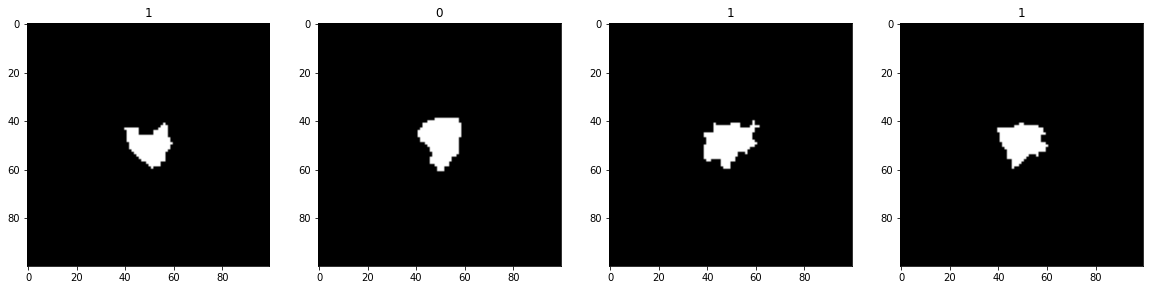

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Batch is composed of two parts : images (batch[0]) and labels (batch[1])

## 1.2. Preprocessing

Data scale

In [ ]:
data.as_numpy_iterator().next()[0].max()

255.0

Split data

In [ ]:
len(data)

81

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [ ]:
print(train_size+val_size+test_size)

81


take defines how much data we take in this partition
skip : skip batches already allocated

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Create a log directory

In [ ]:
logdir='logs' 

Create callbacks (usefull to save model at a particular checkpoint, do specific logging..)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [ ]:
model_dropout = Sequential()  

model_dropout.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_dropout.add(MaxPooling2D())
model_dropout.add(Conv2D(32, (3,3), 1, activation='relu'))
model_dropout.add(MaxPooling2D())
model_dropout.add(Conv2D(16, (3,3), 1, activation='relu'))
model_dropout.add(Dropout(0.2))
model_dropout.add(MaxPooling2D())
model_dropout.add(Flatten())
model_dropout.add(Dense(100, activation='relu'))
model_dropout.add(Dense(1, activation='sigmoid'))

model_dropout.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
hist_dropout = model_dropout.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
56/56 [==============================] - 22s 379ms/step - loss: 2.7617 - accuracy: 0.5670 - val_loss: 0.6615 - val_accuracy: 0.6328
Epoch 2/20
56/56 [==============================] - 26s 468ms/step - loss: 0.6313 - accuracy: 0.6568 - val_loss: 0.5831 - val_accuracy: 0.7031
Epoch 3/20
56/56 [==============================] - 23s 409ms/step - loss: 0.5565 - accuracy: 0.7210 - val_loss: 0.5528 - val_accuracy: 0.7168
Epoch 4/20
56/56 [==============================] - 21s 373ms/step - loss: 0.5001 - accuracy: 0.7467 - val_loss: 0.5214 - val_accuracy: 0.7676
Epoch 5/20
56/56 [==============================] - 23s 409ms/step - loss: 0.4227 - accuracy: 0.8086 - val_loss: 0.4773 - val_accuracy: 0.7500
Epoch 6/20
56/56 [==============================] - 21s 377ms/step - loss: 0.3490 - accuracy: 0.8415 - val_loss: 0.4371 - val_accuracy: 0.7910
Epoch 7/20
56/56 [==============================] - 27s 481ms/step - loss: 0.3035 - accuracy: 0.8650 - val_loss: 0.3786 - val_accuracy: 0.8223

### 1.4.2.2 Plot performance 

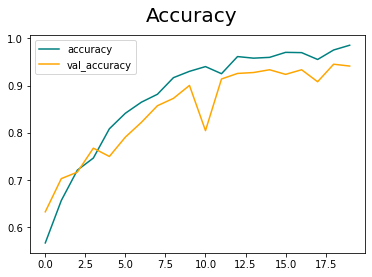

In [ ]:
fig = plt.figure()
plt.plot(hist_dropout.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_dropout.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

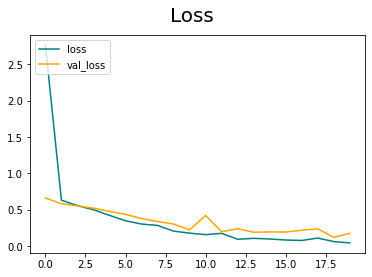

In [ ]:
fig = plt.figure()
plt.plot(hist_dropout.history['loss'], color='teal', label='loss')
plt.plot(hist_dropout.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## test on data

In [ ]:
spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop'

In [ ]:
os.listdir(spe_model_1)

In [ ]:
ypred = []
for image in os.listdir(spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop/{image}')
  preds = model_dropout.predict(np.expand_dims(img, 0))
  ypred.append(preds.round())


In [ ]:
ypred

In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

968

In [ ]:
correct_labels = np.full((968),1)
len(correct_labels)

968

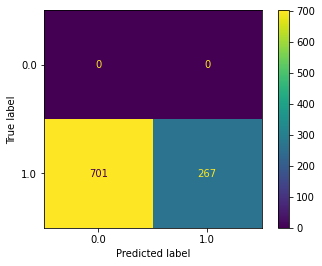

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)